In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 11.7 MB/s eta 0:00:00


# Task 1
Build and train a denoising autoencoder (with at least 4 encoding/decoding
layers) for a dataset of 10 grayscale natural images (e.g., images of houses, cars,
persons) of size 64 × 64. During training use zero-mean Gaussian noise of varying amounts. Consider a meaningful maximum amount of Gaussian noise (your
choice of what “meaningful maximum amount is” will be evaluated). Train until
the performance of the model is really good in your opinion (your choice of what
“really good” is will be evaluated). Evaluate the denoising autoencoder on a separate test set of images. Show the evaluations (see the content description above).
Describe your observations in detail.

In [ ]:
#import libraries
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.io import decode_image
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output,display
%matplotlib inline
import cv2
import os
from typing import Union, Dict, Callable
from functools import cache
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
from itertools import product
from ipywidgets import Output
import pickle
from google.colab import drive

# Denoising Autoencoders
A Denoising Autoencoder (DAE) is a Neural Network that aims to predict an observation $X$ from a corrupted version of it as an input $\tilde{X}$ through a deconstruction process $y = f(g(\tilde{X}))$. Since our dataset consists of images, we will use Convolutional Neural Networks (CNNs) for the encoder $g(\tilde{X})$ and decoder layers $f(g)$. The corruption process will be Gaussian with zero-mean and intensity controlled by $\sigma$
$$C(̃\tilde{X}=\tilde{x}|\, x \,) = \mathcal{N}(\tilde{x}; \mu = x, \Sigma = \sigma^2 I).$$
Since we want the noise to have varying amoung, we will draw the noise for the gaussian with $\sigma$ acting as the maximum amount. We will clip the pixel to be between 0 and 1 to preserve the normalization of the images.

The justification for using CNNs instead of MLPs is that CNNs possess key properties that make them ideal for this experiment. Sparse connectivity allows the network to focus on local regions of the input, while parameter sharing enables it to learn invariant features across different parts of the image. This makes it possible to detect both fine details and larger patterns, leavig us with a more efficient and meaningful representation of the image.

Let's define the functions that add noise to the images.

In [ ]:
#define a zero mean gaussian noise with varying amounts
def distort_img(img:Union[np.ndarray,torch.Tensor], strength: float) -> Union[np.ndarray,torch.Tensor]:

  sigma = strength
  noise = np.random.normal(0, sigma, img.shape)
  return np.clip(img + noise,0,1)

Now, we will use a custom dataset that inherits from PyTorch's Dataset base module.

In [ ]:
#We build a custom dataset class that inherits from PyTorch's Dataset class. We need to override the __len__ and __getitem__ methods.
class ImageDataset(Dataset):
  def __init__(self,folder_path:str,max_size:float=255.0,strength:float = 0.5,transform:Callable = distort_img, copies:int=1, resize : Union[tuple,None]=None,**kwargs):

    self.folder_path = folder_path
    self.max_size = max_size
    self.strength = strength
    self.transform = transform
    self.copies = copies
    self.resize = resize
    self.files = [file for file in os.listdir(self.folder_path) if file.endswith(".jpg")]
  def __len__(self):
    return len(self.files)*self.copies
  @cache
  def __getitem__(self,idx):
    img = decode_image(os.path.join(self.folder_path,self.files[idx//self.copies]),mode="GRAY")
    img = img/self.max_size
    if self.resize:
      img = transforms.Resize(self.resize)(img)

    return self.transform(img,self.strength).float(), img.float()


Several CNNs perform resizing to handle images for their tasks. We will take advantage of the sparse connectivity of CNNs, which allows us to work with variable-size input images. In this experiment, we will train with both standard and resized images to explore which is more useful for constructing the DAE. Since the resized images will have fewer pixels overall, we can expect the model without resizing to perform better. Let's initialize the classes and do some visualization.

In [ ]:
data = ImageDataset("/content")
data_resized = ImageDataset("/content",strength=0.1,resize=(128,128))
validation =  ImageDataset("/content/validation")
validation_resized = ImageDataset("/content/validation",strength=0.1,resize=(128,128))

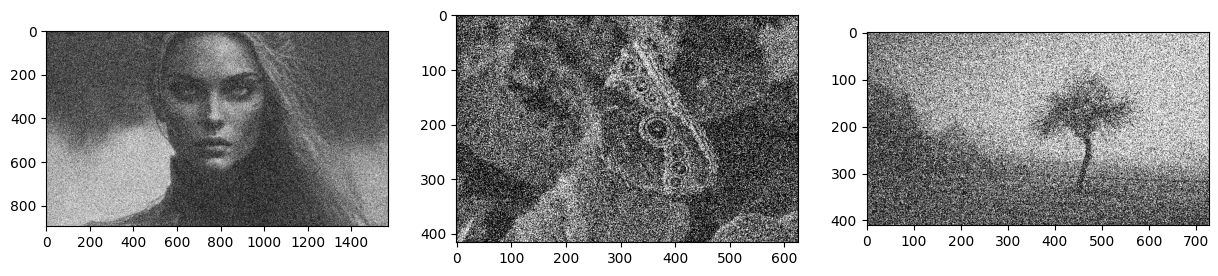

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(1, 3, 1)
plt.imshow(data[0][0] ,cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(data[1][0].permute(1, 2, 0),cmap="gray")
plt.subplot(1, 3, 3)
plt.imshow(data[3][0].permute(1, 2, 0),cmap="gray")

At this point, we will define a class for the DAE. We will develop the class constructor to allow multiple layers for the encoder and decoder, making the module more manageable by enabling the definition of these layers through a dictionary with the desired configurations. Additionally, to resemble scikit-learn models, we will implement the training and evaluation methods as parts of the class itself. Since we are working with inputs of different sizes, we will not use PyTorch's DataLoader capability.
For this particular experiment we will use Relu activation functions, and Kaiming initialization accordingly.
As loss we will use a mix between MSE
$$\text{MSELoss}(X, Y) = \frac{1}{N} \sum_{i=1}^{N} (X_i - Y_i)^2,$$
for pixel fidelity and Structural Similarity Index (SSIM)
$$\text{SSIM}(x, y) = \frac{(2\mu_x\mu_y + C_1)(2\sigma_{xy} + C_2)}{(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)}  = l(x, y) \cdot c(x, y) \cdot s(x, y),$$
where $\mu$ is the mean of the image, $\sigma^2$ the variance, $\sigma_{xy}$ the covariance, and $C_i = (K_i L)^2$, $i=1,2$ constants to stabilize de division, $L$ is the range of the image, in our case, up to $1$ due to normalization, and $K_1 = 0.01$, $K_2=0.03$ typically. We also have
- Luminance:
$$
l(x, y) = \frac{2\mu_x\mu_y + C_1}{\mu_x^2 + \mu_y^2 + C_1}.
$$
- Contrast:
$$
c(x, y) = \frac{2\sigma_x\sigma_y + C_2}{\sigma_x^2 + \sigma_y^2 + C_2}.
$$
- Structure:
$$
s(x, y) = \frac{\sigma_{xy} + C_3}{\sigma_x\sigma_y + C_3},
$$
with $C_3 = C_2/2$. This tell us that this SSIM measures the similarity between two images based on luminance, contrast, and structural information. The mean is measured, for grayscaleimage, as
$$\mu = \frac{1}{H \times W} \sum_{i=1}^H\sum_{j=1}^W I(i,j),$$
with $H$ is the height, $W$ the width and $I(i,j)$ the intensity of the pixel at $(i,j)$. The variance
$$\sigma^2 = \frac{1}{H \times W} \sum_{i=1}^{H} \sum_{j=1}^{W} \left( I(i, j) - \mu \right)^2,
$$
and the covariance
$$\sigma_{xy} = \frac{1}{H \times W} \sum_{i=1}^{H} \sum_{j=1}^{W} \left( x(i, j) - \mu_x \right) \left( y(i, j) - \mu_y \right),
$$ with now $x,y$ the pixel intensities of images $x,y$ respectively. The finall loss will be
$$J(X,\tilde{X}) = \alpha \text{MSE}(X,\tilde{X}) + \beta (1- \text{SSIM}(X,\tilde{X})).$$ $\alpha, \beta$ are hyperparameters to be tuned.

To determine when to stop training, we will track the validation loss on a set of different images and use early stopping. If the validation loss does not improve after a certain number of epochs (patience), we stop the training process and return the model with the parameters that correspond to the best loss value.

As a final comment, the output does not always have the same dimensions as the input when using convolutions. That is why we will crop the input to match the dimensions and compute the MSE in the overlapping regions.

In [ ]:
#Here we define the denoising autoencoder (DAE) that inherits from PyTorch's torch.nn.Module class.
class DAE(torch.nn.Module):
  def __init__(self,encoder_layer_def:Dict[str,Dict[str,Union[int,str]]],decoder_layer_def:Dict[str,Dict[str,Union[int,str]]]):
    """
    Constructor for the Denoising Autoencoder (DAE) class, inheriting from `torch.nn.Module`.

    This constructor defines the overall architecture of the neural network,
    including the encoder and decoder based on the provided layer definitions.
    It also initialises the device (CPU or GPU) and applies Kaiming normal initialisation
    to prevent vanishing or exploding gradients.

    Args:
        encoder_layer_def (Dict[str, Dict[str, Union[int, str]]]):
            A dictionary defining the structure of the encoder layers.
            Each key in the dictionary corresponds to a layer name, and the value is another dictionary
            specifying the layer parameters:
            - `"in_channels"` (int): Number of input channels for the layer.
            - `"out_channels"` (int): Number of output channels for the layer.
            - `"kernel_size"` (int): Size of the convolutional kernel.
            - `"stride"` (int): Stride for the convolution operation.
            Example:
                {
                    "layer1": {"in_channels": 3, "out_channels": 16, "kernel_size": 3, "stride": 1},
                    "layer2": {"in_channels": 16, "out_channels": 32, "kernel_size": 3, "stride": 2}
                }

        decoder_layer_def (Dict[str, Dict[str, Union[int, str]]]):
            A dictionary defining the structure of the decoder layers.
            The format is similar to `encoder_layer_def`, but for deconvolutional layers.

    Attributes:
        encoder (torch.nn.Sequential):
            Sequential container for the encoder layers, built from the provided layer definitions.
        decoder (torch.nn.Sequential):
            Sequential container for the decoder layers, built from the provided layer definitions.
        device (torch.device):
            The device (CPU or GPU) on which the model will be executed. Automatically detects GPU if available.

    Initialisation:
        - Applies Kaiming normal initialisation to all convolutional layers (`torch.nn.Conv2d` in the encoder
          and `torch.nn.ConvTranspose2d` in the decoder) to prevent exploding or vanishing gradients.
        - Bias terms are initialised to zero, if applicable.

    Example:
        >>> encoder_layers = {
                "layer1": {"in_channels": 3, "out_channels": 16, "kernel_size": 3, "stride": 1},
                "layer2": {"in_channels": 16, "out_channels": 32, "kernel_size": 3, "stride": 2}
            }
        >>> decoder_layers = {
                "layer1": {"in_channels": 32, "out_channels": 16, "kernel_size": 3, "stride": 2},
                "layer2": {"in_channels": 16, "out_channels": 3, "kernel_size": 3, "stride": 1}
            }
        >>> model = DAE(encoder_layer_def=encoder_layers, decoder_layer_def=decoder_layers)
        >>> print(model.device)
        cuda:0  # If a GPU is available

    """
    super().__init__()
    self._encoder_layer_def = encoder_layer_def
    self._decoder_layer_def = decoder_layer_def

    self.encoder = self._create_layer("encoder")
    self.decoder = self._create_layer("decoder")

    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.to(self.device)


    #initialization of layers with Kaiming normal initialisation to prevent exploding or vanishing gradients.
    for m in self.encoder.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)
    for m in self.decoder.modules():
            if isinstance(m, torch.nn.ConvTranspose2d):
                torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                  torch.nn.init.zeros_(m.bias)
  def forward(self,X):
     """
    Defines the forward pass of the neural network.

    This function processes the input tensor `X` through the encoder to generate a compressed representation,
    and then passes this representation through the decoder to reconstruct the input.

    Args:
        X (torch.Tensor):
            Input tensor with shape `(batch_size, in_channels, height, width)`,
            where:
            - `batch_size` is the number of input samples in the batch.
            - `in_channels` corresponds to the number of input channels (e.g., 3 for RGB images or 1 for grayscale).
            - `height` and `width` are the spatial dimensions of the input.

    Returns:
        torch.Tensor:
            Reconstructed tensor with the same shape as the input, `(batch_size, in_channels, height, width)`.

     Example:
        >>> dae = DAE(encoder_layer_def=encoder_layers, decoder_layer_def=decoder_layers)
        >>> input_tensor = torch.randn(8, 3, 64, 64)  # Batch of 8 RGB images, 64x64 pixels
        >>> output_tensor = dae(input_tensor)
        >>> print(output_tensor.shape)
        torch.Size([8, 3, 64, 64])
    """

    encoded = self.encoder(X)
    decoded = self.decoder(encoded)
    return decoded

  #GETTERS so the user can see the definition of the model but cannot change later on the architectire, for that the user needs to define another architecture.
  @property
  def encoder_layer_def(self):
    return self._encoder_layer_def

  @property
  def decoder_layer_def(self):
    return self._decoder_layer_def

  @property
  def final_loss_training(self):
    try:
      return self._final_loss_training
    except:
      return None

  @property
  def final_loss_validation(self):
    try:
      return self._final_loss_validation
    except:
      return None


  def _create_conv_layer(self,in_channels:int,out_channels:int,kernel_size:int,stride:int,activation_func:str="ReLU",pooling:Union[str,None]="MaxPool2d",**kwargs):
    """
    Internal function to define a convolutional layer with optional activation and pooling.

    Args:
        in_channels (int): Number of input channels for the convolutional layer.
        out_channels (int): Number of output channels for the convolutional layer.
        kernel_size (int): Size of the convolutional kernel (height and width).
        stride (int): Stride of the convolutional operation.
        activation_func (str, optional): Name of the activation function to use.
            Defaults to "ReLU". Must correspond to a valid class in `torch.nn`.
        pooling (Union[str, None], optional): Name of the pooling layer to apply after the activation.
            Defaults to "MaxPool2d". Set to `None` to skip pooling.
            Must correspond to a valid class in `torch.nn`.
        **kwargs: Additional arguments passed to `torch.nn.Conv2d` (e.g., padding, dilation, etc.).

    Returns:
        torch.nn.Sequential: A sequential container containing the convolutional layer,
        activation function, and optional pooling layer.

    Example:
        >>> conv_layer = self._create_conv_layer(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                activation_func="ReLU",
                pooling="MaxPool2d",
                padding=1
            )
        >>> print(conv_layer)
        Sequential(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
    """
    conv = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,**kwargs)
    activation = getattr(torch.nn,activation_func)()
    if pooling is not None:
      pooling_layer = getattr(torch.nn,pooling)(2)
      return torch.nn.Sequential(conv,activation,pooling_layer)
    else:
      return torch.nn.Sequential(conv,activation)

  def _create_deconv_layer(self,in_channels:int,out_channels:int,kernel_size:int,stride:int,activation_func:str="ReLU",**kwargs):
    """
    Similar to the previous one. Thi one creates a deconvolutional (transpose convolution) layer with an activation function.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        kernel_size (int): Size of the deconvolutional kernel.
        stride (int): Stride for the deconvolution operation.
        activation_func (str, optional): Activation function name (default: "ReLU").
        **kwargs: Additional arguments for `torch.nn.ConvTranspose2d`.

    Returns:
        torch.nn.Sequential: A sequential layer with deconvolution and activation.
    """
    deconv = torch.nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,**kwargs)
    activation = getattr(torch.nn,activation_func)()
    return torch.nn.Sequential(deconv,activation)

  def _create_layer(self,layer_type:str):
    """
    Constructs a sequential layer (encoder or decoder) based on the provided configuration.

    This method builds the encoder or decoder by iterating through the layer definitions
    and creating either convolutional or deconvolutional layers dynamically.

    Args:
        layer_type (str):
            The type of layer to construct. Must be either:
            - `"encoder"`: Creates a sequence of convolutional layers.
            - `"decoder"`: Creates a sequence of deconvolutional layers.

    Raises:
        ValueError:
            - If `layer_type` is invalid.
            - If required keys (`"in_channels"`, `"out_channels"`, `"kernel_size"`, `"stride"`)
              are missing in the layer definitions.
            - If any key has a value of an unsupported type.

    Returns:
        torch.nn.Sequential:
            A sequential container of layers based on the configuration.
    """
    if layer_type not in ["encoder","decoder"]:
      raise ValueError("Layer type should be either encoder or decoder.")

    layer_def = getattr(self,f"_{layer_type}_layer_def")

    layers= []
    if "in_channels" not in layer_def[list(layer_def.keys())[0]].keys():
      raise ValueError("Missing key in_channels in the first layer.")
    else:
      for layer_name, layer_conf in layer_def.items():

        if "in_channels" in locals():
          layer_conf["in_channels"] =  locals()["in_channels"]

        for req_key in ["out_channels","kernel_size","stride"]:
          if req_key not in layer_conf.keys():
            raise ValueError(f"Missing key {req_key} in layer {layer_name}")
          else:
            if not isinstance(layer_conf[req_key],Union[int,str]):
              raise ValueError(f"Value of key {req_key} in layer {layer_name} should be int or str.")
            else:
              if layer_type == "encoder":
                layers.append(self._create_conv_layer(**layer_conf))
                break
              else:
                layers.append(self._create_deconv_layer(**layer_conf))
                break
              in_channels = layer_conf["out_channels"]
      return torch.nn.Sequential(*layers)

  def _output_shape(self,input_size:int,**kwargs):
    """
    Calculates the output spatial size of a convolutional or deconvolutional layer.

    This method determines the output size along one spatial dimension (height or width)
    based on the input size and layer parameters, using the formula:

        output_size = (input_size - 1) * stride - 2 * padding + kernel_size

    Args:
        input_size (int):
            The size of the input along one spatial dimension (height or width).
        **kwargs:
            Additional layer parameters, including:
            - `"stride"` (int): The stride of the convolution or deconvolution.
            - `"padding"` (int): The padding applied to the input.
            - `"kernel_size"` (int): The size of the kernel/filter.

    Returns:
        int:
            The calculated output size along the same spatial dimension.

    Raises:
        KeyError: If any of the required keys (`"stride"`, `"padding"`, or `"kernel_size"`)
        are missing from `kwargs`.
    """
    return (input_size-1)*kwargs["stride"] - 2*kwargs["padding"] + kwargs["kernel_size"]

  def test_model(self,validation_data):
    """
    Evaluates the model's performance on a validation or test dataset.

    This method sets the model to evaluation mode, disables gradient calculation,
    and computes the average loss over the dataset.

    Args:
        validation_data (ImageDataset):
            The custom ImageDataset containing the validation or test dataset.

    Returns:
        float:
            The average loss computed over the entire dataset, rounded to 5 decimal places.

    Example:
        Assuming a trained model and a validation set`validation`:
        ```python
        avg_loss = model.test_model(validation)
        print(f"Validation Loss: {avg_loss}")
        ```
    """
    self.eval()

    running_loss = 0
    with torch.no_grad():
      for obs in validation_data:
        X, Y = obs[0].to(self.device), obs[1].to(self.device)
        outputs = self(X)

        loss = self.criterion(outputs, Y)
        running_loss += loss.item()
    return round(running_loss/len(validation_data),5)

  def criterion(self,pred,Y, loss_parameters:dict = {"alpha":0.5,"beta":0.5}):
    """
    Computes the combined loss function using Mean Squared Error (MSE) and Structural Similarity Index (SSIM).

    Args:
        pred (torch.Tensor):
            The predicted output tensor, the model’s prediction for an image.
            Should have shape `[batch_size, channels, height, width]` for image data.
        Y (torch.Tensor):
            The ground truth tensor, containing the true target values (e.g., true images).
            Should have the same shape as `pred`.
        loss_parameters (dict, optional):
            A dictionary containing the weights for MSE and SSIM terms. Default is `{"alpha": 0.5, "beta": 0.5}`.
            - `"alpha"` (float): Weight for the MSE loss term.
            - `"beta"` (float): Weight for the SSIM loss term.

    Returns:
        torch.Tensor:
            The computed loss value, combining MSE and SSIM according to the weights provided.
    """
    MSE = torch.nn.MSELoss()
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(self.device)
    loss = loss_parameters["alpha"]*MSE(pred,Y[:,:pred.shape[1],:pred.shape[2]]) + loss_parameters["beta"]*(1-ssim(pred.unsqueeze(0),Y[:,:pred.shape[1],:pred.shape[2]].unsqueeze(0)))
    return loss
  def train_model(self,training_data,validation_data,optimizer=torch.optim.Adam, learning_rate:float = 0.001,patience:int=10,num_epochs:Union[int,None]=None,alpha:float=0.5,beta:float=0.5,**kwargs):
    """
    Trains the model using a custom training loop with early stopping and validation.

    This method trains the model for a specified number of epochs or until early stopping is triggered
    based on validation loss. It supports both manual setting of the number of epochs and a dynamic training
    approach using early stopping if `num_epochs` is not provided. The model is evaluated on both training and
    validation datasets after each epoch, and the loss is tracked for both.

    Args:
        training_data (ImageDataset):
            An instance of the custom ImageDataset providing the training dataset. It yields pairs of input distorted data (`X`) and ground truth images (`Y`).
        validation_data (torch.utils.data.DataLoader):
            An instance of the custom ImageDataset providing the validation dataset. It yields pairs of input distorted data (`X`) and ground truth images (`Y`).
        optimizer (torch.optim.Optimizer, optional):
            The optimizer to use for training (default: Adam). You can provide any optimizer supported by PyTorch.
        learning_rate (float, optional):
            The learning rate for the optimizer (default: 0.001).
        patience (int, optional):
            The number of epochs to wait for an improvement in validation loss before stopping early (default: 10).
        num_epochs (int, optional):
            The maximum number of epochs to train for. If `None`, early stopping based on validation loss is used.
        alpha (float, optional):
            Weight for the MSE loss term in the combined loss function (default: 0.5).
        beta (float, optional):
            Weight for the SSIM loss term in the combined loss function (default: 0.5).
        **kwargs: Additional parameters for the optimizer or other configurations.

    Returns:
        tuple:
            A tuple containing:
            - The final training loss after all epochs (`float`).
            - The final validation loss after all epochs (`float`).

    Example:
        ```python
        train_loss, val_loss = model.train_model(train_data, val_data, optimizer=torch.optim.Adam,
                                                 learning_rate=0.001, patience=10)
        print(f"Training Loss: {train_loss}, Validation Loss: {val_loss}")
        ```
    """
    optimizer = optimizer(self.parameters(), lr=learning_rate)

    self.train()
    loss_values_training = []
    loss_values_validation = []

    best_loss = float('inf')
    epochs_without_improvement = 0
    best_model_weights = None

    if num_epochs is None:

      while epochs_without_improvement < patience:
        running_loss = 0

        for obs in training_data:
          X, Y = obs[0].to(self.device), obs[1].to(self.device)
          optimizer.zero_grad()
          outputs = self(X)
          loss = self.criterion(outputs,Y,loss_parameters={"alpha":alpha,"beta":beta})
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

        loss_values_training.append(round(running_loss/len(data),5))

        loss_values_validation.append(self.test_model(validation_data))

        clear_output(wait=True)
        print(f"Params: alpha = {alpha}, beta = {beta}, learning_rate= {learning_rate}, max_noise = {training_data.strength}")
        print(f"Epoch [{len(loss_values_training)}], Loss training: {loss_values_training[-1]:.5f}, Loss validation {loss_values_validation[-1]:.5f}")
        plt.plot(range(1, len(loss_values_training) + 1), loss_values_validation,label='Validation Loss', color='red')
        plt.plot(range(1, len(loss_values_training) + 1), loss_values_training,label='Training Loss', color='blue')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss per Epoch')
        plt.legend()
        plt.grid(True)
        plt.show()
        if loss_values_validation[-1] < best_loss:
          best_loss = loss_values_validation[-1]
          best_model_weights = self.state_dict()
          epochs_without_improvement = 0
        else:
          epochs_without_improvement += 1

      self.load_state_dict(best_model_weights)
    else:
      for epoch in range(num_epochs):
        running_loss = 0
        for obs in training_data:
          X, Y = obs[0].to(self.device), obs[1].to(self.device)
          optimizer.zero_grad()
          outputs = self(X)
          loss = self.criterion(outputs, Y[:,:outputs.shape[1],:outputs.shape[2]])
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

        loss_values_training.append(round(running_loss/len(data),5))

        loss_values_validation.append(self.test_model(validation_data))

        clear_output(wait=True)
        print(f"Params: alpha = {alpha}, beta = {beta}, learning_rate= {learning_rate}, max_noise = {training_data.strength}")
        print(f"Epoch [{len(loss_values_training)}], Loss training: {loss_values_training[-1]:.5f}, Loss validation {loss_values_validation[-1]:.5f}")
        plt.plot(range(1, len(loss_values_training) + 1), loss_values_validation,label='Validation Loss', color='red')
        plt.plot(range(1, len(loss_values_training) + 1), loss_values_training,label='Training Loss', color='blue')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss per Epoch')
        plt.legend()
        plt.grid(True)
        plt.show()




    self._final_loss_validation = loss_values_validation[-1]
    self._final_loss_training = loss_values_training[-1]
    return loss_values_training[-1], loss_values_validation[-1]
  def reset_parameters(self):
     """
    Resets the weights and biases of the model's convolutional layers to a predefined initialization.

    This method applies Kaiming normal initialization to the encoder's `Conv2d` layers and the decoder's
    `ConvTranspose2d` layers, suitable for ReLU activations. Biases are initialized to zeros.

    Useful for restarting training with random initialization.
    """
    for m in self.encoder.modules():
      if isinstance(m, torch.nn.Conv2d):
          torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
          if m.bias is not None:
              torch.nn.init.zeros_(m.bias)
    for m in self.decoder.modules():
      if isinstance(m, torch.nn.ConvTranspose2d):
          torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
          if m.bias is not None:
            torch.nn.init.zeros_(m.bias)


The following layers are crafted to try to preserve as much as possible the dimensions from the original input. This is done considering that after a convolution, any dimension (Weight and Height) of the output is
$$D_{\text{out}} = \left\lfloor \frac{D_{\text{in}} - K + 2P}{S} \right\rfloor + 1, \quad D \in \{H,W\}$$, and  the output from a Conv transpose is $$D_{\text{out}} = S \times (D_{\text{in}} - 1) + K - 2P.
$$

In [ ]:
encoder_layer_def = {"layer_1":{"in_channels":1,"out_channels":20,"kernel_size":3,"stride":1},
                     "layer_2":{"in_channels":20,"out_channels":10,"kernel_size":4,"stride":1},
                     "layer_3":{"in_channels":10,"out_channels":5,"kernel_size":5,"stride":1},
                     "layer_4":{"in_channels":5,"out_channels":3,"kernel_size":5,"stride":1}}

decoder_layer_def = {"layer_1":{"in_channels":3,"out_channels":5,"kernel_size":6,"stride":2},
                     "layer_2":{"in_channels":5,"out_channels":10,"kernel_size":6,"stride":2},
                     "layer_3":{"in_channels":10,"out_channels":20,"kernel_size":5,"stride":2},
                     "layer_4":{"in_channels":20,"out_channels":1,"kernel_size":4,"stride":2}}
model =  DAE(encoder_layer_def,decoder_layer_def)

In [ ]:
encoder_layer_def = {"layer_1":{"in_channels":1,"out_channels":20,"kernel_size":3,"stride":1},
                     "layer_2":{"in_channels":20,"out_channels":10,"kernel_size":4,"stride":1},
                     "layer_3":{"in_channels":10,"out_channels":5,"kernel_size":5,"stride":1},
                     "layer_4":{"in_channels":5,"out_channels":3,"kernel_size":5,"stride":1}}

decoder_layer_def = {"layer_1":{"in_channels":3,"out_channels":5,"kernel_size":7,"stride":2},
                      "layer_2":{"in_channels":5,"out_channels":10,"kernel_size":6,"stride":2},
                      "layer_3":{"in_channels":10,"out_channels":20,"kernel_size":5,"stride":2},
                     "layer_4":{"in_channels":20,"out_channels":1,"kernel_size":4,"stride":2},
                     }

model_res = DAE(encoder_layer_def,decoder_layer_def)

# Resizing or not
We will now proceed to traing two version of the DAE with the same weigths for bot MSE and SSIM, one on the unaltered images, and the second with resized images. We will see then which one performs the best.

Params: alpha = 0.5, beta = 0.5, learning_rate= 0.0001, max_noise = 0.5
Epoch [1024], Loss training: 0.17891, Loss validation 0.24508


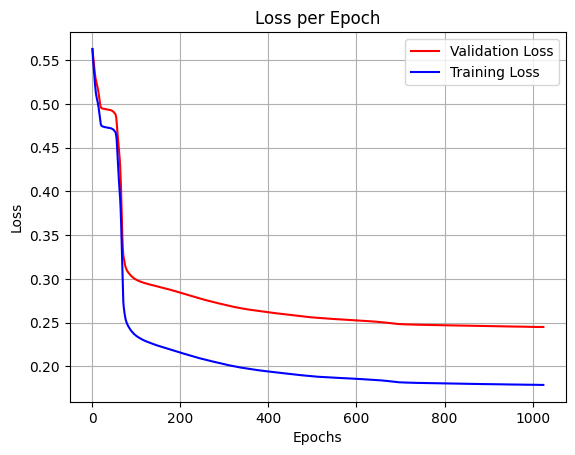

(0.17891, 0.24508)

In [ ]:
model.train_model(training_data = data, validation_data=validation,learning_rate=0.0001)

Params: alpha = 0.5, beta = 0.5, learning_rate= 0.0001, max_noise = 0.1
Epoch [311], Loss training: 0.27295, Loss validation 0.42871


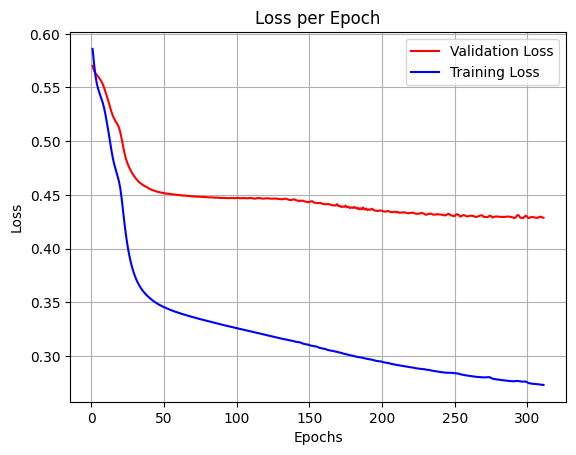

(0.27295, 0.42871)

In [ ]:
model_res.train_model(training_data = data_resized, validation_data=validation_resized,learning_rate=0.0001,patience=20)

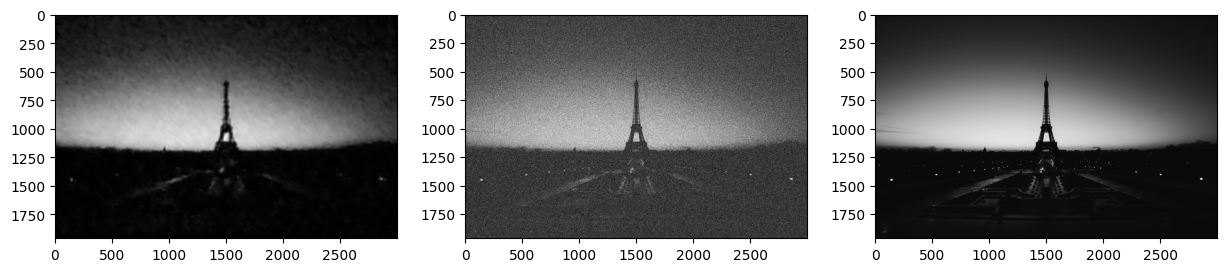

In [ ]:
i=0
plt.figure(figsize=(15,15))
plt.subplot(1, 3, 1)
plt.imshow(model(data[i][0].to("cuda")).cpu().permute(1, 2, 0).detach().numpy() ,cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(data[i][0].permute(1, 2, 0),cmap="gray")
plt.subplot(1, 3, 3)
plt.imshow(data[i][1].permute(1, 2, 0),cmap="gray")

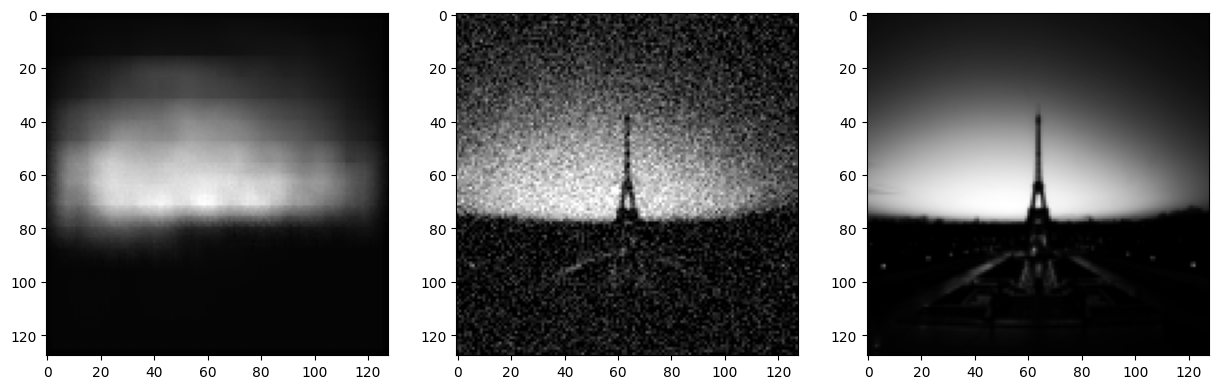

In [ ]:
i=0
plt.figure(figsize=(15,15))
plt.subplot(1, 3, 1)
plt.imshow(model_res(data_resized[i][0].to("cuda")).cpu().permute(1, 2, 0).detach().numpy() ,cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(data_resized[i][0].permute(1, 2, 0),cmap="gray")
plt.subplot(1, 3, 3)
plt.imshow(data_resized[i][1].permute(1, 2, 0),cmap="gray")

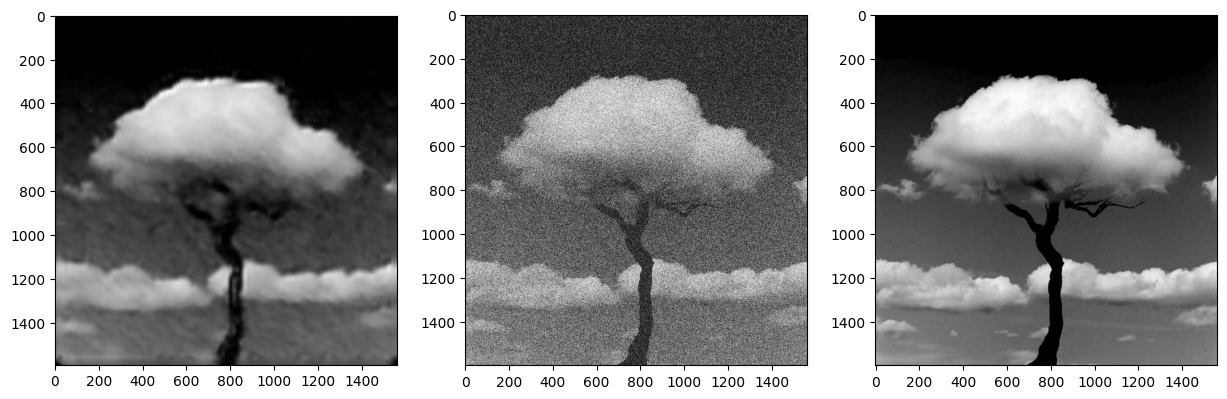

In [ ]:
i=1
plt.figure(figsize=(15,15))
plt.subplot(1, 3, 1)
plt.imshow(model(validation[i][0].to("cuda")).cpu().permute(1, 2, 0).detach().numpy() ,cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(validation[i][0].permute(1, 2, 0),cmap="gray")
plt.subplot(1, 3, 3)
plt.imshow(validation[i][1].permute(1, 2, 0),cmap="gray")

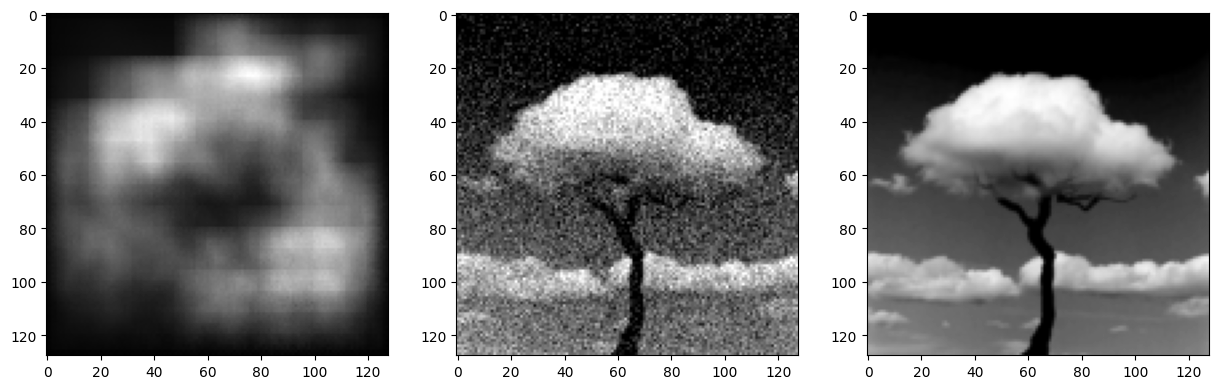

In [ ]:
i=1
plt.figure(figsize=(15,15))
plt.subplot(1, 3, 1)
plt.imshow(model_res(validation_resized[i][0].to("cuda")).cpu().permute(1, 2, 0).detach().numpy() ,cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(validation_resized[i][0].permute(1, 2, 0),cmap="gray")
plt.subplot(1, 3, 3)
plt.imshow(validation_resized[i][1].permute(1, 2, 0),cmap="gray")

As we can see from the validation errors, even with large patience and low noise, the DAE with resized images performs worse that the one with the whole images. We then conclude that resizing is not advisable and we will proceed with the model trained with the unaltered data.

# Maximum strength and tunning
We will consider the maximum strength of noise to be an hyperparameter along with the learning rate $\eta$ and the weigths of the losses $\alpha$ and $\beta$.
Due to computational limitations, we will first try to tune the $\alpha$ and $\beta$ hyperparameters, then we will try to fix the maximum strength of the noise and finally we will fix the learning rate for the final training.
We proceed with a gridsearch and select the combination of parameters that yields the best validation loss.

In [ ]:
encoder_layer_def = {"layer_1":{"in_channels":1,"out_channels":20,"kernel_size":3,"stride":1},
                     "layer_2":{"in_channels":20,"out_channels":10,"kernel_size":4,"stride":1},
                     "layer_3":{"in_channels":10,"out_channels":5,"kernel_size":5,"stride":1},
                     "layer_4":{"in_channels":5,"out_channels":3,"kernel_size":5,"stride":1}}

decoder_layer_def = {"layer_1":{"in_channels":3,"out_channels":5,"kernel_size":6,"stride":2},
                     "layer_2":{"in_channels":5,"out_channels":10,"kernel_size":6,"stride":2},
                     "layer_3":{"in_channels":10,"out_channels":20,"kernel_size":5,"stride":2},
                     "layer_4":{"in_channels":20,"out_channels":1,"kernel_size":4,"stride":2}}


In [ ]:
def tune_hyperparameters(model,param_grid:dict,training_data,validation_data,plot:bool=False):
  """
    Tunes hyperparameters using grid search.

    Args:
        model (torch.nn.Module): The model to be trained.
        param_grid (dict): A dictionary of hyperparameters and their possible values.
        training_data (Dataset): Training dataset.
        validation_data (Dataset): Validation dataset.
        plot (bool, optional): Whether to plot training and validation loss. Default is False.

    Returns:
        tuple: Best hyperparameter combination and the corresponding validation loss.

    Example:
        param_grid = {"learning_rate": [0.001, 0.01], "batch_size": [32, 64]}
        best_combination, best_loss = tune_hyperparameters(model, param_grid, train_data, val_data)
  """
  best_loss = float("inf")

  cross_product = [dict(zip(param_grid.keys(), combination)) for combination in product(*param_grid.values())]

  for combination in cross_product:
    model.reset_parameters()
    display(f"Current combination: {combination}")
    training = ImageDataset("/content",**combination)
    validation = ImageDataset("/content/validation",**combination)
    _, val_loss = model.train_model(training_data = training, validation_data=validation,**combination)
    if val_loss < best_loss:
      best_loss = val_loss
      best_combination = combination
      if plot:
        print(f"New best combination: {best_combination} with loss {best_loss}")
  return best_combination, best_loss

In [ ]:
param_grid = {"learning_rate" : [0.001],
              "alpha":[0.1,0.3,0.6],
              "beta":[0.1,0.3,0.6]}
model =  DAE(encoder_layer_def,decoder_layer_def)

Params: alpha = 0.6, beta = 0.6, learning_rate= 0.001, max_noise = 0.5
Epoch [576], Loss training: 0.34823, Loss validation 0.33283


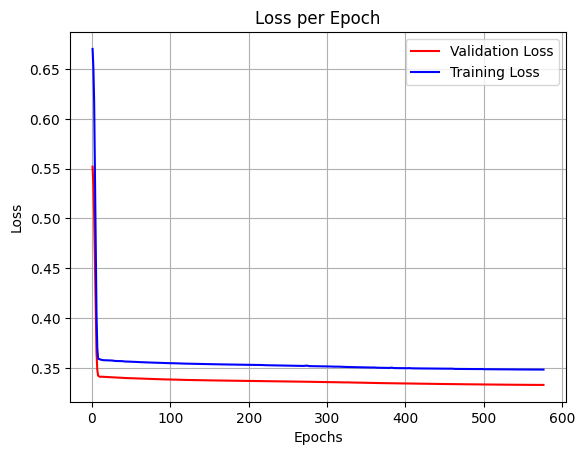

In [ ]:
best_combination, best_loss = tune_hyperparameters(model,param_grid,data,validation)

In [ ]:
print(best_combination, best_loss )

{'learning_rate': 0.001, 'alpha': 0.6, 'beta': 0.1} 0.24746


Once we tuned the parameters for the loss, we will proceed to select a max strength noise

Params: alpha = 0.6, beta = 0.1, learning_rate= 0.001, max_noise = 0.9
Epoch [102], Loss training: 0.04493, Loss validation 0.26117


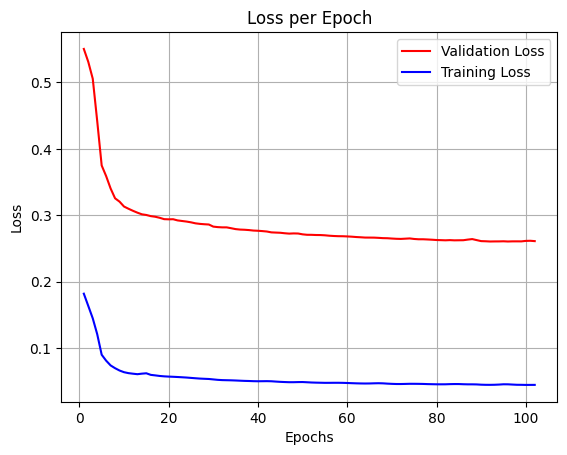

In [ ]:
losses= []
for strength in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
  data = ImageDataset("/content",strength=strength)
  validation = ImageDataset("/content/validation",strength=strength)
  model =  DAE(encoder_layer_def,decoder_layer_def)
  train_loss, val_loss= model.train_model(training_data = data, validation_data=validation,**{'learning_rate': 0.001, 'alpha': 0.6, 'beta': 0.1})
  losses.append((train_loss,val_loss))


Text(0.5, 0, 'Strength of Noise')

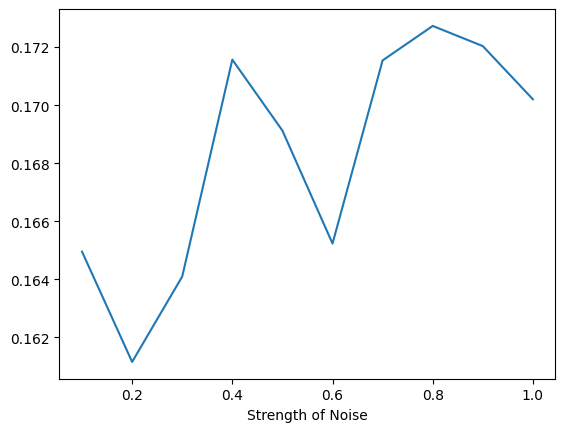

In [ ]:
ratio_loss = [loss[0]/loss[1] for loss in losses]
strengths = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
plt.plot(strengths, ratio_loss, label='Training Loss')
plt.xlabel('Strength of Noise')


From the ratio between the training and validation loss, we see that we can choose a strength of 0.6 since it is the largest one tested that does nto yield a high difference between validation and ttraining.

For the final training, we will choose a learning rate as small as computing resources let us, and also will use a validation test for the early stopping, but with a distinct validation set as before, this is only for the final run.

In [ ]:
train_a = ImageDataset("/content",strength=0.6)
train_b = ImageDataset("/content/validation",strength=0.6)
training_data = torch.utils.data.ConcatDataset([train_a,train_b])
training_data.strength = 0.6
validation_data = ImageDataset("/content/final_validation",strength=0.6)

Params: alpha = 0.6, beta = 0.1, learning_rate= 1e-05, max_noise = 0.6
Epoch [5467], Loss training: 0.06663, Loss validation 0.30925


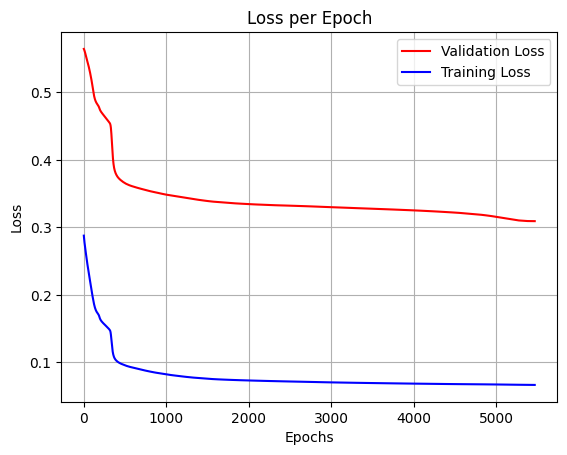

(0.06663, 0.30925)

In [ ]:
model =  DAE(encoder_layer_def,decoder_layer_def)
model.train_model(training_data = training_data, validation_data=validation_data,learning_rate=0.00001,patience=20, alpha=0.6, beta=0.1)

In [ ]:
#### save the model for later use
filename = '/content/drive/My Drive/model.pkl'
with open(filename, 'wb') as f:
    pickle.dump(model, f)

We see that on the validation set we have a loss of about 0.31, if the model generalizes well on unseen data we'd expect a loss about that on the test set.

Loss :  tensor(0.2520, device='cuda:0', grad_fn=<AddBackward0>)


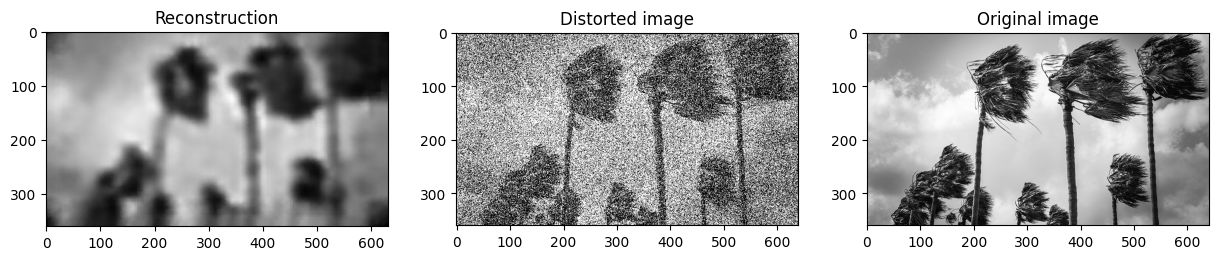

Loss :  tensor(0.3281, device='cuda:0', grad_fn=<AddBackward0>)


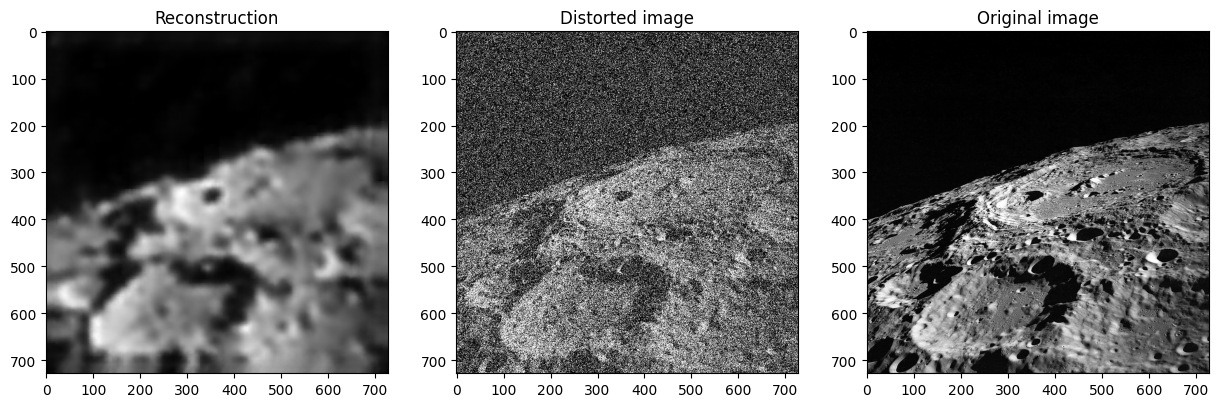

Loss :  tensor(0.0504, device='cuda:0', grad_fn=<AddBackward0>)


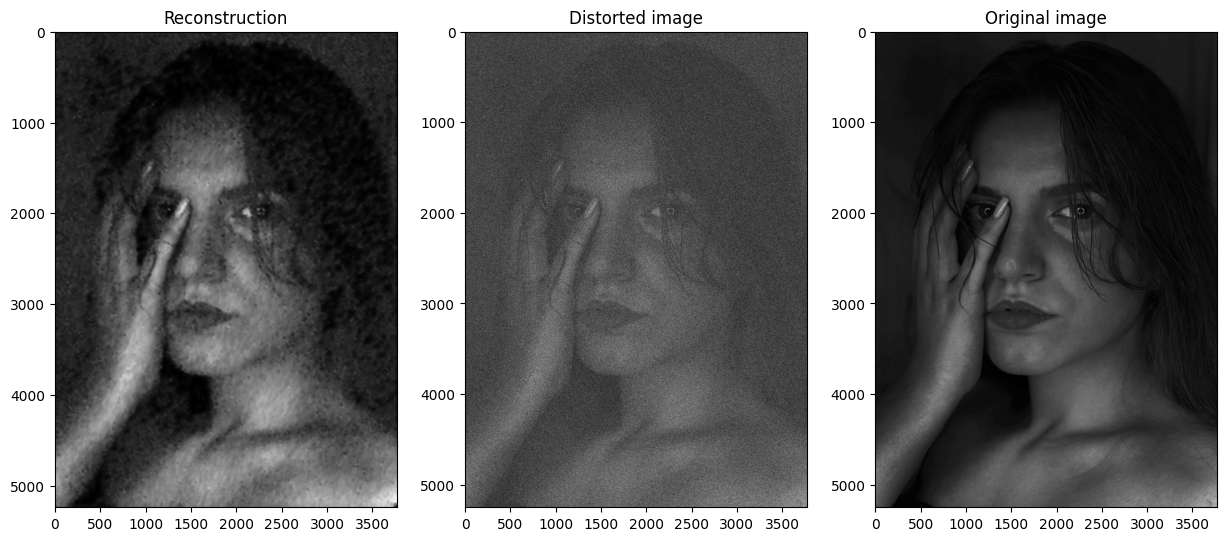

Loss :  tensor(0.1741, device='cuda:0', grad_fn=<AddBackward0>)


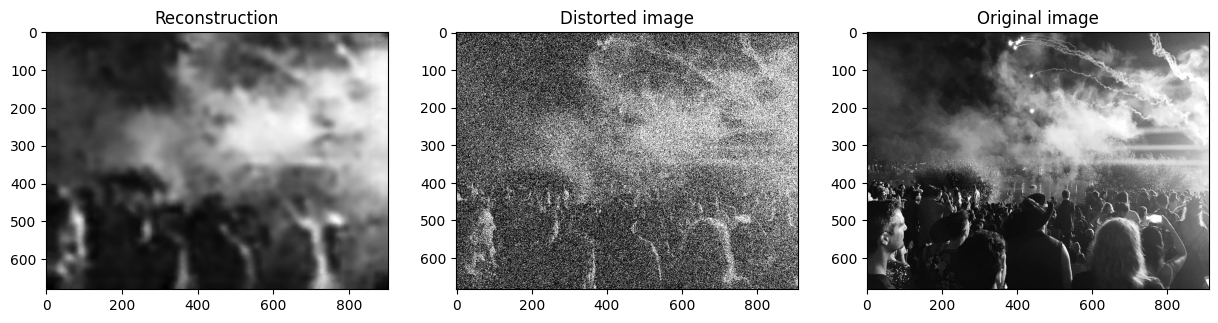

Loss :  tensor(0.2770, device='cuda:0', grad_fn=<AddBackward0>)


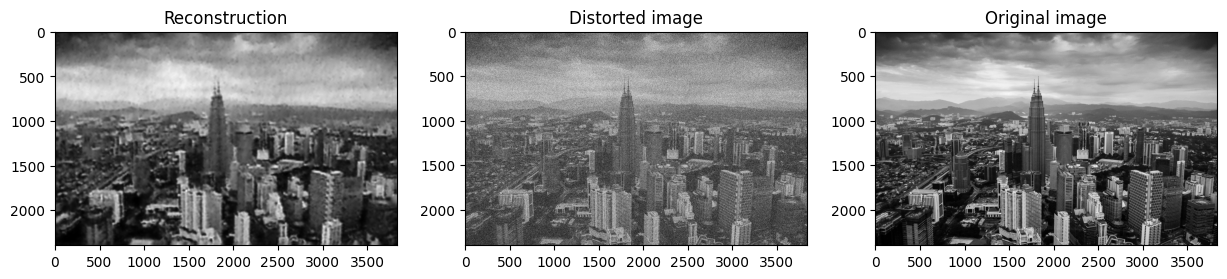

In [ ]:
test = ImageDataset("/content/test",strength=0.6)
model.eval()
for i in range(len(test)):
  plt.figure(figsize=(15,15))
  plt.subplot(1, 3, 1)
  pred = model(test[i][0].to("cuda"))
  print("Loss : ", model.criterion(pred,test[i][1].to("cuda")))
  im1 = plt.imshow(pred.cpu().permute(1, 2, 0).detach().numpy(),cmap="gray")
  plt.title("Reconstruction")
  plt.subplot(1, 3, 2)
  plt.imshow(test[i][0].permute(1, 2, 0),cmap="gray")
  plt.title("Distorted image")
  plt.subplot(1, 3, 3)
  plt.imshow(test[i][1].permute(1, 2, 0),cmap="gray")
  plt.title("Original image")
  plt.show()

We see that the model performs well on unseen data, with the greatest loss on the test set to be about the same of that on the validation set. We can alos explore more extreme conditions of distortion to see how the model performs to unseen levels of distortion.

Loss :  tensor(0.2725, device='cuda:0', grad_fn=<AddBackward0>)


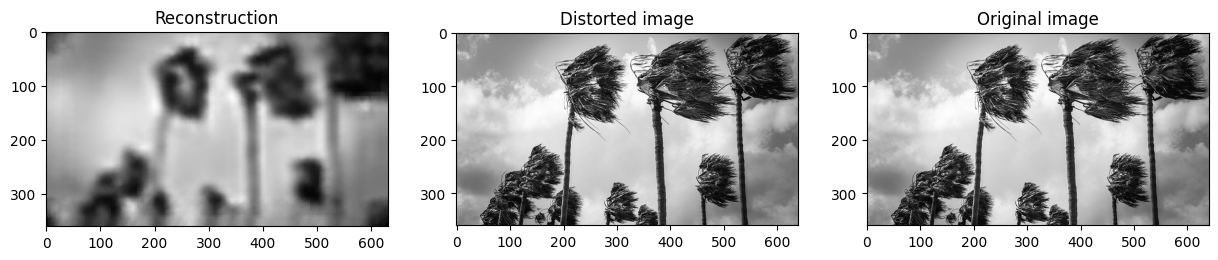

Loss :  tensor(0.3708, device='cuda:0', grad_fn=<AddBackward0>)


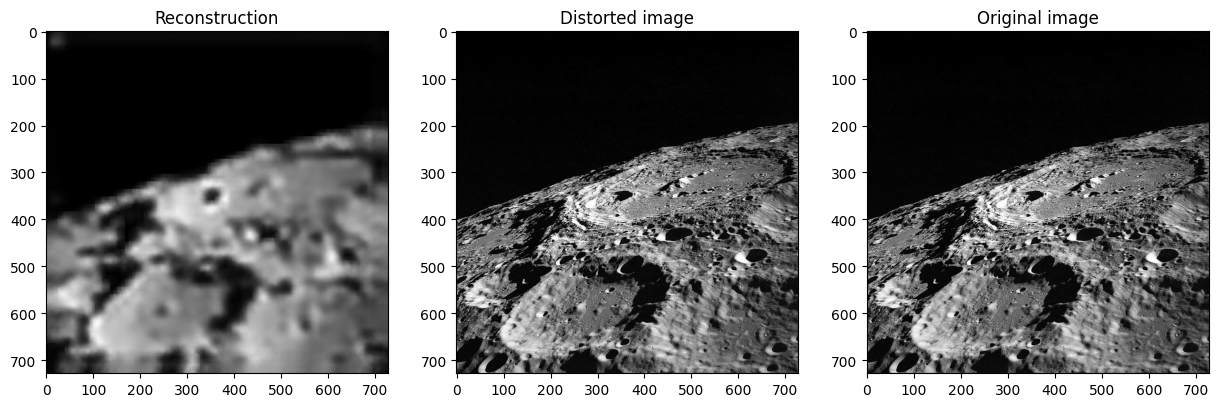

Loss :  tensor(0.0694, device='cuda:0', grad_fn=<AddBackward0>)


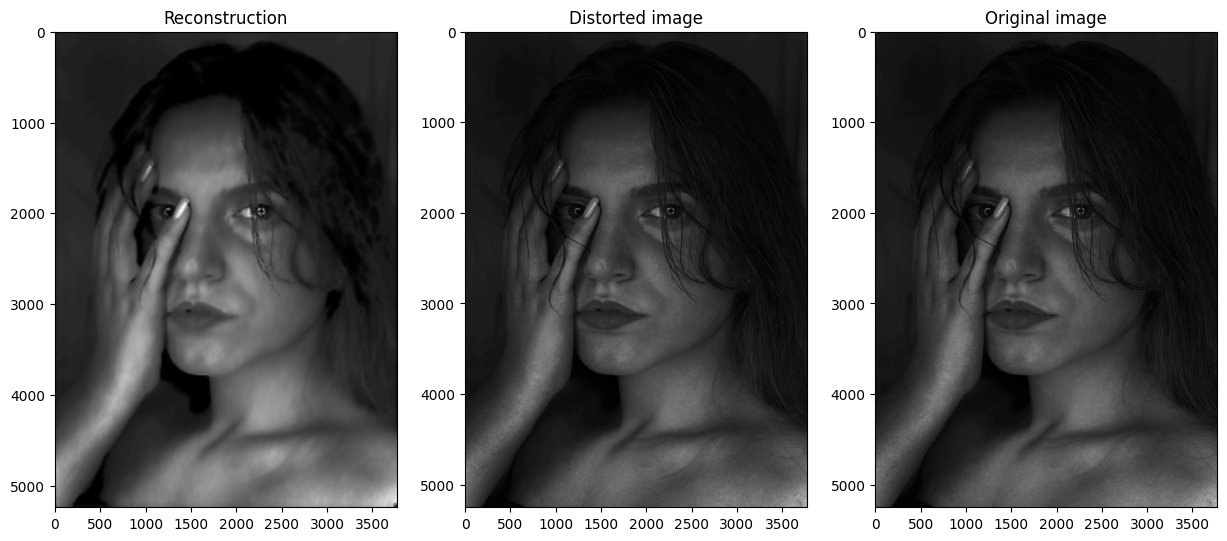

Loss :  tensor(0.2090, device='cuda:0', grad_fn=<AddBackward0>)


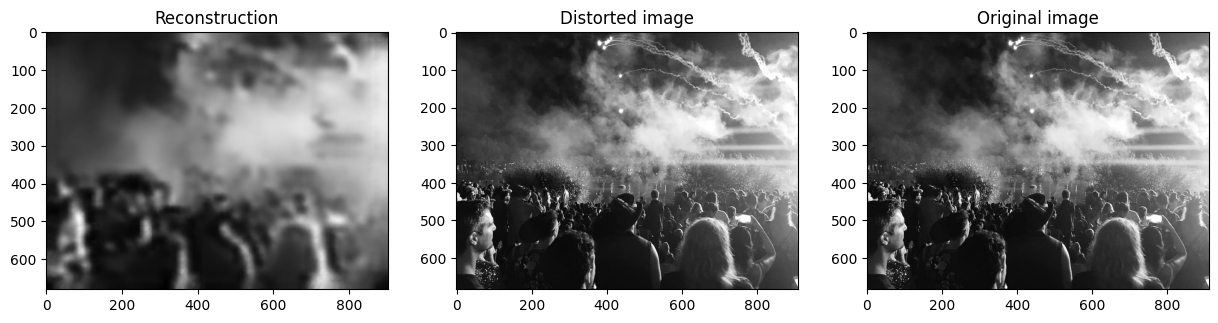

Loss :  tensor(0.2990, device='cuda:0', grad_fn=<AddBackward0>)


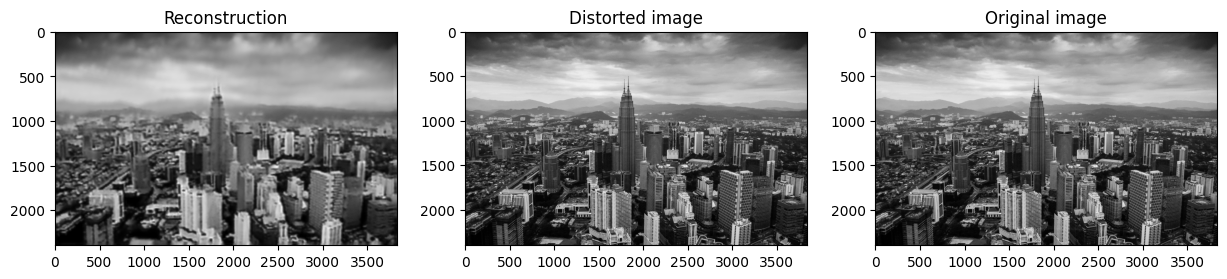

In [ ]:
test = ImageDataset("/content/test",strength=0.001)
model.eval()
for i in range(len(test)):
  plt.figure(figsize=(15,15))
  plt.subplot(1, 3, 1)
  pred = model(test[i][0].to("cuda"))
  print("Loss : ", model.criterion(pred,test[i][1].to("cuda")))
  im1 = plt.imshow(pred.cpu().permute(1, 2, 0).detach().numpy(),cmap="gray")
  plt.title("Reconstruction")
  plt.subplot(1, 3, 2)
  plt.imshow(test[i][0].permute(1, 2, 0),cmap="gray")
  plt.title("Distorted image")
  plt.subplot(1, 3, 3)
  plt.imshow(test[i][1].permute(1, 2, 0),cmap="gray")
  plt.title("Original image")
  plt.show()


We can conclude that reducing the maximum noise distortion does not highly improve the loss on the test set, this is a good indicator since this implies that the DAE did not learn the identity mapping $f(g(x))=x$

Loss :  tensor(0.2618, device='cuda:0', grad_fn=<AddBackward0>)


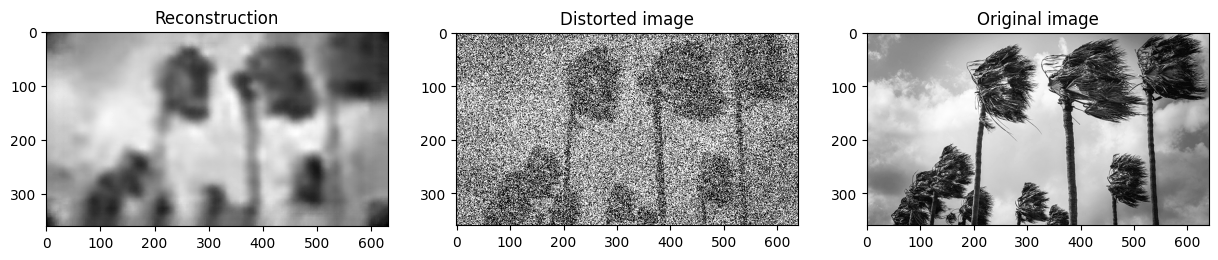

Loss :  tensor(0.4294, device='cuda:0', grad_fn=<AddBackward0>)


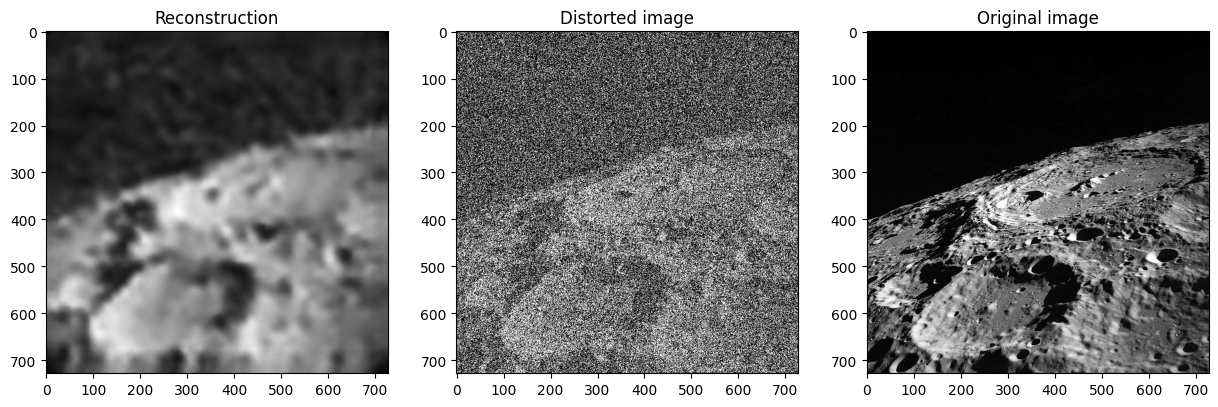

Loss :  tensor(0.1092, device='cuda:0', grad_fn=<AddBackward0>)


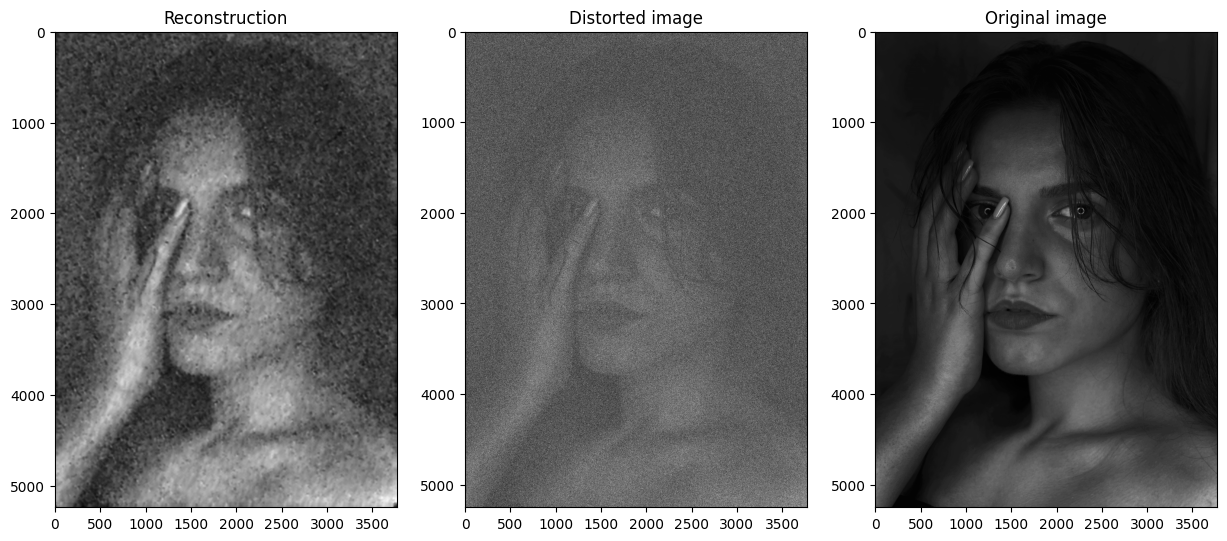

Loss :  tensor(0.1972, device='cuda:0', grad_fn=<AddBackward0>)


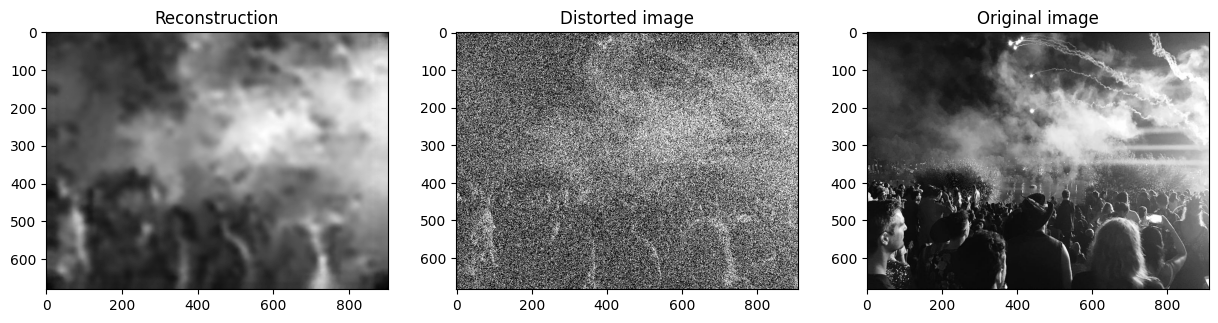

Loss :  tensor(0.2950, device='cuda:0', grad_fn=<AddBackward0>)


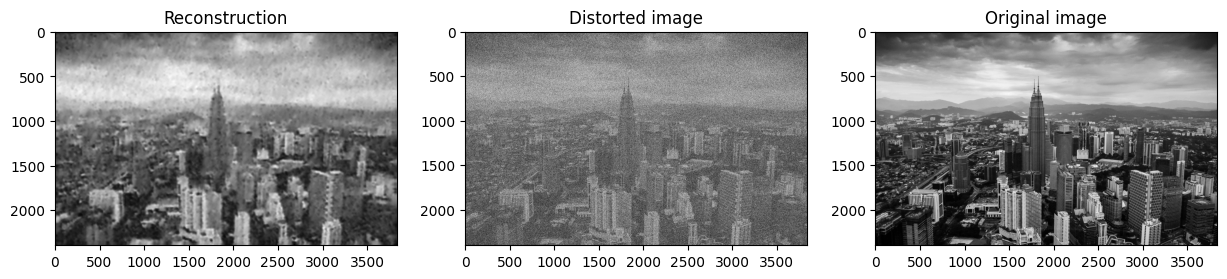

In [ ]:
test = ImageDataset("/content/test",strength=1)
model.eval()
for i in range(len(test)):
  plt.figure(figsize=(15,15))
  plt.subplot(1, 3, 1)
  pred = model(test[i][0].to("cuda"))
  print("Loss : ", model.criterion(pred,test[i][1].to("cuda")))
  im1 = plt.imshow(pred.cpu().permute(1, 2, 0).detach().numpy(),cmap="gray")
  plt.title("Reconstruction")
  plt.subplot(1, 3, 2)
  plt.imshow(test[i][0].permute(1, 2, 0),cmap="gray")
  plt.title("Distorted image")
  plt.subplot(1, 3, 3)
  plt.imshow(test[i][1].permute(1, 2, 0),cmap="gray")
  plt.title("Original image")
  plt.show()

We can also see that the model performs decently even with a greater distortion.